<a href="https://colab.research.google.com/github/CobaMasa/RStan2PyStan/blob/20200422/chapter8_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression with Hierarchical Model
    Objective: Make hierarchical logistic regression using all observed variables (and Of course (one) hidden variable).

the model we made in the chapter before:
$$
\begin{eqnarray}
    q[i]&=&inv\_logit(b_1+b_2A[i]+b_3Score[i]+b_4Weather[i])\\
    Y[i]&〜&Bernoulli(q[i])
\end{eqnarray}
$$

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
import seaborn as sns

import pystan

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
base = 'drive/My Drive/Colab/RStanBook/chap08/input/'
attend4_1 = pd.read_csv(base+'data-attendance-4-1.txt')
attend4_2 = pd.read_csv(base+'data-attendance-4-2.txt')
print('- Attendance4-1.txt\nshape{}, columns: {}'.format(attend4_1.shape, attend4_1.columns))
print()
print('- Attendance4-2.txt\nshape{}, columns: {}'.format(attend4_2.shape, attend4_2.columns))
attend4_2.head()
master = pd.merge(attend4_2, attend4_1, how='left', on=['PersonID'])
print('-master:\nshape: {}, columns: {}'.format(master.shape, master.columns))
master.head()

- Attendance4-1.txt
shape(50, 3), columns: Index(['PersonID', 'A', 'Score'], dtype='object')

- Attendance4-2.txt
shape(2396, 4), columns: Index(['PersonID', 'CourseID', 'Weather', 'Y'], dtype='object')
-master:
shape: (2396, 6), columns: Index(['PersonID', 'CourseID', 'Weather', 'Y', 'A', 'Score'], dtype='object')


,PersonID,CourseID,Weather,Y,A,Score
0,1,3,B,1,0,69
1,1,9,A,1,0,69
2,1,1,C,1,0,69
3,1,9,A,1,0,69
4,1,7,B,1,0,69


In [0]:
StanData = {
    'N': len(master.PersonID.unique()),
    'C': len(master.CourseID.unique()),
    'I': master.shape[0],
    'A': attend4_1.A.values,
    'Score': attend4_1.Score.values/200,
    'PID': master.PersonID.values,
    'CID': master.CourseID.values,
    'W': master.Weather.map({'A': 0, 'B': 0.2, 'C': 1}).values,
    'Y': master.Y.values
}

In [4]:
from google.colab import files
files.upload()

Saving model8-8.stan to model8-8 (1).stan


{'model8-8.stan': b'data {\n  int N;\n  int C;\n  int I;\n  int<lower=0, upper=1> A[N];\n  real<lower=0, upper=1> Score[N];\n  int<lower=1, upper=N> PID[I];\n  int<lower=1, upper=C> CID[I];\n  real<lower=0, upper=1> W[I];\n  int<lower=0, upper=1> Y[I];\n}\n\nparameters {\n  real b[4];\n  real b_P[N];\n  real b_C[C];\n  real<lower=0> s_P;\n  real<lower=0> s_C;\n}\n\ntransformed parameters {\n  real x_P[N];\n  real x_C[C];\n  real x_J[I];\n  real x[I];\n  real q[I];\n  for (n in 1:N)\n    x_P[n] = b[2]*A[n] + b[3]*Score[n] + b_P[n];\n  for (c in 1:C)\n    x_C[c] = b_C[c];\n  for (i in 1:I) {\n    x_J[i] = b[4]*W[i];\n    x[i] = b[1] + x_P[PID[i]] + x_C[CID[i]] + x_J[i];\n    q[i] = inv_logit(x[i]);\n  }\n}\n\nmodel {\n  for (n in 1:N)\n    b_P[n] ~ normal(0, s_P);\n  for (c in 1:C)\n    b_C[c] ~ normal(0, s_C);\n  for (i in 1:I)\n    Y[i] ~ bernoulli(q[i]);\n}\n'}

In [6]:
sm = pystan.StanModel(file='model8-8.stan')
fit = sm.sampling(data=StanData, n_jobs=-1)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_05935f457d7b722a971dda9c9eda8ab9 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)



For the full summary use 'print(fit)'

Inference for Stan model: anon_model_05935f457d7b722a971dda9c9eda8ab9.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
b[1]      0.83    0.02    0.6   -0.35    0.43   0.83   1.21   2.01    759   1.01
b[2]      -0.8  3.1e-3   0.15    -1.1    -0.9   -0.8   -0.7   -0.5   2446    1.0
b[3]      1.71    0.01    0.6    0.57    1.32    1.7   2.11   2.91   2697    1.0
b[4]     -0.78  1.7e-3   0.14   -1.06   -0.88  -0.78  -0.68   -0.5   7078    1.0
b_P[1]    0.27  4.9e-3   0.31   -0.29    0.07   0.26   0.45   0.96   3978    1.0
b_P[2]   -0.36  4.5e-3   0.27   -0.91   -0.54  -0.35  -0.17   0.13   3568    1.0
b_P[3]   -0.28  4.4e-3   0.31   -0.93   -0.47  -0.27  -0.06    0.3   4900    1.0
b_P[4]    0.39  5.0e-3   0.28   -0.13    0.19   0.37   0.56   0.96   3115    1.0
b_P[5]   -0.01  3.6e-3   0.28   -0.57    -

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


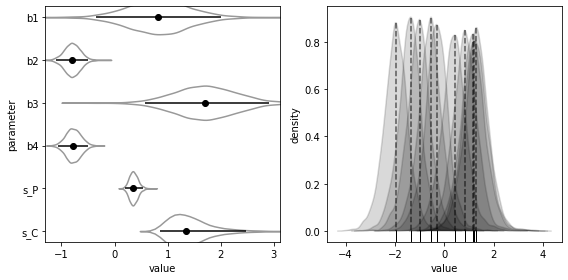

In [7]:
ms = fit.extract()
N_mcmc = ms['lp__'].size

param_names = ['mcmc'] + ['b{}'.format(i+1) for i in range(4)] + ['s_P', 's_C']
d_est = pd.DataFrame(np.hstack([np.arange(N_mcmc).reshape((-1, 1)), ms['b'], ms['s_P'].reshape((-1, 1)), ms['s_C'].reshape((-1, 1))]), columns=param_names)
d_qua = d_est.loc[:, param_names[1:]].quantile((0.025, 0.5, 0.975)).T.reset_index()
d_qua.columns = ('X', 'p2.5', 'p50', 'p97.5')
d_qua['X'] = pd.Categorical(d_qua['X'])
d_melt = pd.melt(d_est, id_vars=('mcmc'), var_name='X')
d_melt['X'] = pd.Categorical(d_melt['X'])

_, (ax1, ax2) = plt.subplots(1, 2, figsize=figaspect(1/2))
sns.violinplot('value', 'X', data=d_melt, order=param_names[1:], scale='width', inner=None, orient='h', color='w', ax=ax1)
ax1.errorbar('p50', 'X', data=d_qua, xerr=[d_qua['p50']-d_qua['p2.5'], d_qua['p97.5']-d_qua['p50']], fmt='o', c='k')
plt.setp(ax1, xlabel='value', ylabel='parameter')

param_names = ['mcmc'] + ['b_C{}'.format(i+1) for i in range(10)]
d_est = pd.DataFrame(np.hstack([np.arange(N_mcmc).reshape((-1, 1)), ms['b_C']]), columns=param_names)

def get_map(col):
    kernel = stats.gaussian_kde(col)
    dens_x = np.linspace(col.min(), col.max(), kernel.n)
    dens_y = kernel.pdf(dens_x)
    mode_i = np.argmax(dens_y)
    mode_x = dens_x[mode_i]
    mode_y = dens_y[mode_i]
    return pd.Series([mode_x, mode_y], index=['X', 'Y'])

d_mode = d_est.loc[:, param_names[1:]].apply(get_map).T

d_est.loc[:, param_names[1:]].apply(lambda s: sns.kdeplot(s, shade=True, legend=False, color='k', alpha=0.15, ax=ax2))
ax2.vlines(d_mode['X'], d_mode['Y'], 0, linestyles='dashed', alpha=0.6)
sns.rugplot(d_mode['X'], color='k', ax=ax2)
plt.setp(ax2, xlabel='value', ylabel='density', xticks=np.arange(-4, 5, 2))
plt.tight_layout()

plt.show()